Upload DVAE mode

In [0]:
from google.colab import files
files.upload()

!pip install torch torchvision tqdm scipy

In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import autograd
from torchvision import transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from tqdm import tqdm
from torchvision.utils import make_grid as make_image_grid
import PIL
# from skimage.io import imread
from scipy.misc import imread, imsave
from scipy.stats import norm

import random

In [0]:
MODEL_PARAM_PATH = '../dataset/mask_creation/'

In [0]:
class CDVAE(nn.Module):
  
  IMAGE_SIZE_ONE_DIM = 64
  IMAGE_SIZE = IMAGE_SIZE_ONE_DIM*IMAGE_SIZE_ONE_DIM

  def __init__(self,latent_dim=15,hidden_dim=100):
    super(CDVAE,self).__init__()

    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn3 = nn.BatchNorm2d(32)
    self.conv4 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1, bias=False)
    self.bn4 = nn.BatchNorm2d(16)

    self.fc_e2 = nn.Linear(16*16*16, hidden_dim)

    self.fc_mean = nn.Linear(hidden_dim,latent_dim)
    self.fc_logvar = nn.Linear(hidden_dim,latent_dim)

    self.fc_d1 = nn.Linear(latent_dim, hidden_dim)
    self.fc_d2 = nn.Linear(hidden_dim, 16*16*16)
#         self.fc_d2 = nn.Linear(hidden_dim, self.IMAGE_SIZE)

    self.conv5 = nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
    self.bn5 = nn.BatchNorm2d(32)
    self.conv6 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn6 = nn.BatchNorm2d(32)
    self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
    self.bn7 = nn.BatchNorm2d(16)
    self.conv8 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1, bias=False)

  def encoder(self,x_in):

    conv1 = F.relu(self.bn1(self.conv1(x_in)))
    conv2 = F.relu(self.bn2(self.conv2(conv1)))
    conv3 = F.relu(self.bn3(self.conv3(conv2)))
    conv4 = F.relu(self.bn4(self.conv4(conv3)))
    
    
    x = conv4.view(-1, self.num_flat_features(conv4))

    x = F.relu(self.fc_e2(x))

    mean = self.fc_mean(x)
    logvar = self.fc_logvar(x)
    return mean, logvar

  def decoder(self,z):
    z = F.relu(self.fc_d1(z))
    z = F.relu(self.fc_d2(z))

    z = z.view(-1, 16, 16, 16)


    conv5 = F.relu(self.bn5(self.conv5(z)))
    conv6 = F.relu(self.bn6(self.conv6(conv5)))
    conv7 = F.relu(self.bn7(self.conv7(conv6)))
    x_out = self.conv8(conv7)
    x_out = F.sigmoid(x_out)
  
  
    return x_out

  def sample_normal(self, mean, logvar):
    # Using torch.normal(means,sds) returns a stochastic tensor which we cannot backpropogate through.
    # Instead we utilize the 'reparameterization trick'.
    # http://stats.stackexchange.com/a/205336
    # http://dpkingma.com/wordpress/wp-content/uploads/2015/12/talk_nips_workshop_2015.pdf
    sd = torch.exp(logvar*0.5)
    e = Variable(torch.randn(sd.size())).cuda() # Sample from standard normal
    z = e.mul(sd).add_(mean)
    return z

  def forward(self,x_in):
#         print(x_in.shape)
    z_mean, z_logvar = self.encoder(x_in)
    z = self.sample_normal(z_mean,z_logvar)

    x_out = self.decoder(z)
    return x_out, z_mean, z_logvar

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features


# Loss function# Loss  
BETA = 3

def criterion(x_out,x_in,z_mu,z_logvar):

  bce_loss = F.binary_cross_entropy(x_out,x_in,size_average=False)
  kld_loss = -0.5 * torch.sum(1 + z_logvar - (z_mu ** 2) - torch.exp(z_logvar))
  loss = (bce_loss + BETA * kld_loss) / x_out.size(0) # normalize by batch size
  return loss

In [0]:
LATENT_SIZE = 10

model2 = CDVAE(latent_dim=LATENT_SIZE)
model2.load_state_dict(torch.load('dvae_model'))
model2.cuda()

CDVAE(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_e2): Linear(in_features=4096, out_features=100, bias=True)
  (fc_mean): Linear(in_features=100, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=100, out_features=10, bias=True)
  (fc_d1): Linear(in_features=10, out_features=100, bias=True)
  (fc_d2): Linear(in_f

In [0]:
num=20
range_space = np.linspace(-10,10,num)

range_space

array([-10.        ,  -8.94736842,  -7.89473684,  -6.84210526,
        -5.78947368,  -4.73684211,  -3.68421053,  -2.63157895,
        -1.57894737,  -0.52631579,   0.52631579,   1.57894737,
         2.63157895,   3.68421053,   4.73684211,   5.78947368,
         6.84210526,   7.89473684,   8.94736842,  10.        ])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


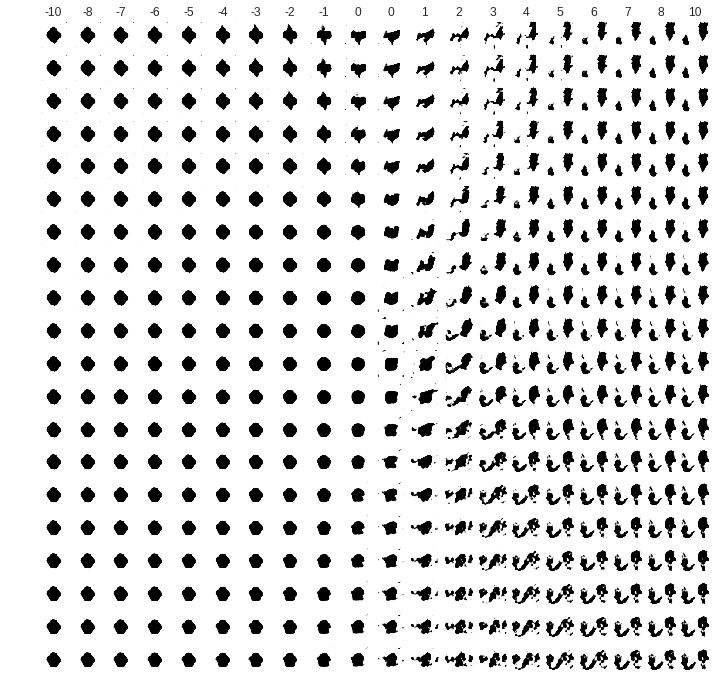

In [0]:
Z_DIM1 = 3
Z_DIM2 = 4

z = torch.zeros(LATENT_SIZE).cuda()

fig, ax = plt.subplots(20,20, figsize=(12,12))

for i, n in enumerate(range_space):
  z[Z_DIM1] = n
  
  for j, m in enumerate(range_space):
    z[Z_DIM2] = m
    out = model2.decoder(z)
    ax[i, j].imshow(out.view(64,64).detach().cpu().numpy())
    ax[i, j].axis('off')
    if i==0:
      ax[i, j].set_title(int(m))
    if j==0:
      ax[i, j].set_ylabel(int(n), rotation=0, size='large')
      
plt.show()

tensor([ 0.3357,  0.7090, -0.3304,  0.4725,  0.3945, -2.7778,  1.2886, -3.4156,
        -2.4876, -0.0164], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


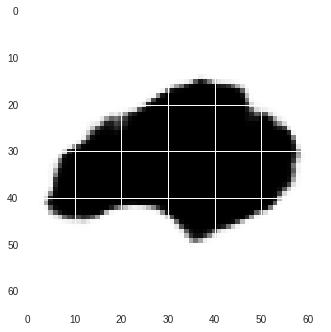

In [0]:
z = np.random.normal(loc=0.0, scale=2.0, size=LATENT_SIZE)
z = torch.Tensor(z).cuda()

out = model2.decoder(z)

print(z)

plt.imshow(out[0,0].cpu().detach().numpy())
plt.show()

49


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


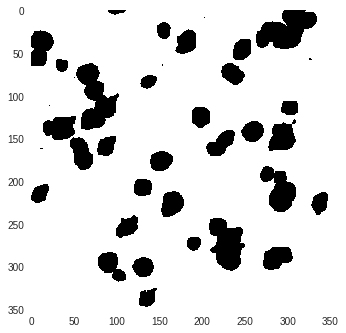

45


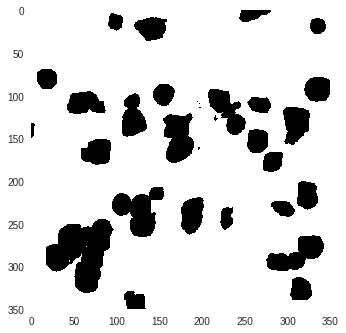

32


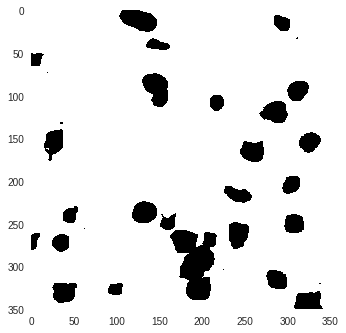

42


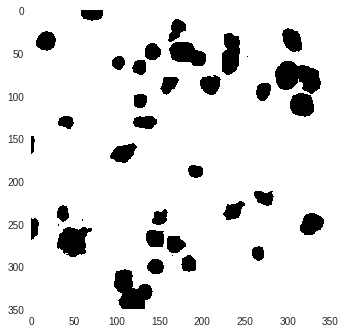

44


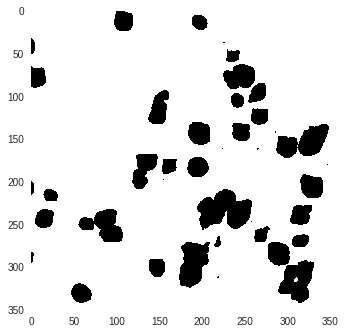

55


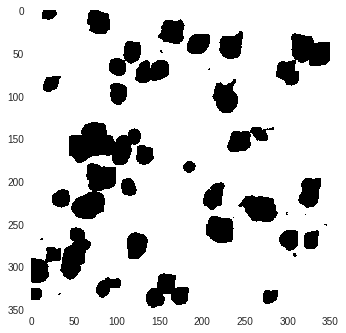

In [0]:
MAX_SCALE = 1
GENERATED_IMAGE_SIZE = 350
MEAN = 45.57
SD = 7.47
NUMBER_OF_GENERATED_IMAGES = 6
SAVED_PATH = "generated_mask/"

PADDING_SIZE = 64 * MAX_SCALE


for j in range(NUMBER_OF_GENERATED_IMAGES):
  
  generated_mask = np.zeros((GENERATED_IMAGE_SIZE + PADDING_SIZE, GENERATED_IMAGE_SIZE + PADDING_SIZE))
  
#   number_of_nuclei = random.randint(5, 12)
  number_of_nuclei = int(np.random.normal(MEAN, SD))
  print(number_of_nuclei)
  
#   print(number_of_nuclei)

  for i in range(number_of_nuclei):

#     z = (torch.rand(LATENT_SIZE)*4).cuda()
    z = np.random.normal(loc=0.0, scale=0.5, size=LATENT_SIZE)
    z = torch.Tensor(z).cuda()
    out = model2.decoder(z)


    rand_x, rand_y = random.randint(0, 350), random.randint(0, 350)
    rand_scale = random.uniform(0.5, MAX_SCALE)

    new_size = int(rand_scale * 64)

    img = F.upsample(out, size=(new_size, new_size), mode='bilinear')

    generated_mask[rand_x:rand_x+new_size, rand_y:rand_y+new_size] = np.maximum(
        generated_mask[rand_x:rand_x+new_size, rand_y:rand_y+new_size],
        img.view(new_size,new_size).detach().cpu().numpy())



  #   plt.imshow(out.view(64,64).detach().cpu().numpy())
  #   plt.show()

  generated_mask = generated_mask[PADDING_SIZE//2:-PADDING_SIZE//2, 
                                  PADDING_SIZE//2:-PADDING_SIZE//2]
#   print(generated_mask.shape)
  generated_mask[generated_mask>=0.5] = 1
  generated_mask[generated_mask<0.5] = 0
  
#   print(np.unique(generated_mask))
  plt.imshow(generated_mask)
  plt.grid(False)
  plt.show()
  
  if not os.path.isdir(SAVED_PATH):
    os.mkdir(SAVED_PATH)
    
  imsave(f"{SAVED_PATH}{j}.png", generated_mask)


In [0]:
!tar -cvzf generated_mask.tar.gz generated_mask

from google.colab import files
files.download('generated_mask.tar.gz')

generated_mask/
generated_mask/4.png
generated_mask/3.png
generated_mask/1.png
generated_mask/2.png
generated_mask/5.png
generated_mask/0.png


## Verify generated masks

In [0]:
!ls

datalab  dvae_model  generated_mask  nuclei-library-master


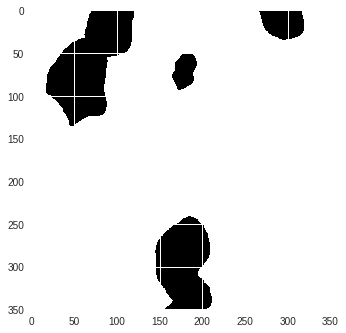

In [0]:
image = imread(SAVED_PATH + '1.png')
np.unique(image)

plt.imshow(image)
plt.show()